In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.math import reduce_mean

## Loading the dataset

In [2]:
(training_images, training_labels), (testing_images, testing_labels) = tf.keras.datasets.mnist.load_data()

## Scaling the data between 0 and 1

In [3]:
training_images = training_images/255.0

In [4]:
training_dataset = tf.data.Dataset.from_tensor_slices(training_images)

## Shuffling the images

In [5]:
BUFFER_SIZE = 60000
training_dataset = training_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)

## Creating batches

In [6]:
BATCH_SIZE = 100
training_dataset = training_dataset.batch(BATCH_SIZE)

## Defining generator model

In [7]:
def generatorModel():
    inp = Input(80)
    x = Dense(7*7*256, activation="relu")(inp)
    x = Reshape((7,7,256))(x) #At this step the image has 128 channels.
    x = Conv2DTranspose(filters = 128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = Conv2DTranspose(filters = 64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = Conv2D(filters = 1, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)
    model = tf.keras.Model(inputs=(inp), outputs=(x))
    model.summary()
    return model

## Defining discriminator model

In [8]:
def discriminatorModel():
    inp = Input((28,28,1))
    x = Conv2D(filters = 16, kernel_size=3, strides=2, padding="same", activation="relu")(inp) #now 14,14,16
    x = Dropout(.1)(x)
    x = Conv2D(filters = 64, kernel_size=3, strides=2, padding="same", activation="relu")(x) #now only 7,7,64
    x = Dropout(.1)(x)
    x = Flatten()(x) #Compress the dimensions to be 3136 (7x7x32)
    x = Dense(1568, activation="sigmoid")(x) #Use all nodes from the previous layer to create one value.
    x = Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=(inp), outputs=(x))
    model.summary()
    return model

## Creating the models and printing summary

In [9]:
generator = generatorModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense (Dense)               (None, 12544)             1016064   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 1)         577   

In [10]:
discriminator = discriminatorModel()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          9280      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 1568)              4918

## Creating functions to save and load the weights

In [11]:
def saveModel(model, filename):
    model.save_weights("Models\\" + filename + "ckpt")

In [12]:
def loadModel(model, filename):
    model.load_weights("Models/" + filename + "ckpt")
    return model

## Creating the optimizers

In [13]:
discOpt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99)
genOpt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99)

## Defining the loss functions

In [14]:
def genLossFunc(discGenOutput):
    return K.mean(tf.math.log(1 - discGenOutput))

In [15]:
def disLossFunc(discSampleOutput, discGenOutput):
    return -1 * K.mean(tf.math.log(discSampleOutput) + tf.math.log(1 - discGenOutput))

## Creating function for training step

In [16]:
@tf.function
def trainingStep(images, noise):
    with tf.GradientTape() as genTape, tf.GradientTape() as discTape:
        genOutput = generator(noise, training=True)

        discSampleOutput = discriminator(images, training=True)
        discGenOutput = discriminator(genOutput, training=True)

        genLoss = genLossFunc(discGenOutput)
        disLoss = disLossFunc(discSampleOutput, discGenOutput)

    genGradients = genTape.gradient(genLoss, generator.trainable_variables)
    discGradients = discTape.gradient(disLoss, discriminator.trainable_variables)

    genOpt.apply_gradients(zip(genGradients, generator.trainable_variables))
    discOpt.apply_gradients(zip(discGradients, discriminator.trainable_variables))
    
    return genLoss, disLoss

## Creating function to save images

In [17]:
def saveImages(generatorOutput, epoch_count):
    fig = plt.figure(figsize=(10,10))
    
    for i in range(100):
        ax = fig.add_subplot(10,10,i+1)
        im = np.clip(generatorOutput[i], 0.0, 1.0).squeeze() * 255
#         ax.set_title(f"({i})")
        ax.imshow(im, cmap="gray", vmin=0, vmax=255)
        ax.axis('off')
        
    fig.savefig("Images\\epoch " + str(epoch_count) + ".png")

    plt.close(fig)

## Training loop for 100 epochs that prints average loss value and saves the model weights and images after each epoch

In [18]:
epochs = 100

for i, epoch in enumerate(range(epochs)):
    
    genLossVals = []
    disLossVals = []
    
    for j, batch in enumerate(training_dataset):
        
        noise = np.random.normal(0, 1, size=(100, 80))

        genLossVal, disLossVal = trainingStep(batch, noise)
        genLossVals.append(genLossVal)
        disLossVals.append(disLossVal)
        
        print(f"{j} / {len(training_dataset)} steps completed in epoch {i}\r", end="")

    print(f"\nFor epoch {i} average loss value for generator is {tf.math.reduce_mean(genLossVals)} and discriminator is {tf.math.reduce_mean(disLossVals)}")
    
    saveModel(generator, "generator-" + str(epoch))
    saveModel(discriminator, "discriminator-" + str(epoch))

    noise = np.random.normal(0, 1, size=(100, 80))
    generatorOutput = generator(noise, training=False)
    saveImages(generatorOutput, i)

599 / 600 steps completed in epoch 0
For epoch 0 average loss value for generator is -0.14081716537475586 and discriminator is 0.26997315883636475
599 / 600 steps completed in epoch 1
For epoch 1 average loss value for generator is -0.3424634635448456 and discriminator is 0.6416860222816467
599 / 600 steps completed in epoch 2
For epoch 2 average loss value for generator is -0.6830832362174988 and discriminator is 1.382681131362915
599 / 600 steps completed in epoch 3
For epoch 3 average loss value for generator is -0.6525925397872925 and discriminator is 1.3063970804214478
599 / 600 steps completed in epoch 4
For epoch 4 average loss value for generator is -0.6363689303398132 and discriminator is 1.2772469520568848
599 / 600 steps completed in epoch 5
For epoch 5 average loss value for generator is -0.6453147530555725 and discriminator is 1.2937648296356201
599 / 600 steps completed in epoch 6
For epoch 6 average loss value for generator is -0.6555358171463013 and discriminator is 1.3

599 / 600 steps completed in epoch 56
For epoch 56 average loss value for generator is -0.5713368654251099 and discriminator is 1.1347562074661255
599 / 600 steps completed in epoch 57
For epoch 57 average loss value for generator is -0.5678977370262146 and discriminator is 1.1285618543624878
599 / 600 steps completed in epoch 58
For epoch 58 average loss value for generator is -0.5663566589355469 and discriminator is 1.1256603002548218
599 / 600 steps completed in epoch 59
For epoch 59 average loss value for generator is -0.5643801093101501 and discriminator is 1.121185064315796
599 / 600 steps completed in epoch 60
For epoch 60 average loss value for generator is -0.5652238130569458 and discriminator is 1.1230536699295044
599 / 600 steps completed in epoch 61
For epoch 61 average loss value for generator is -0.5617449283599854 and discriminator is 1.116702675819397
599 / 600 steps completed in epoch 62
For epoch 62 average loss value for generator is -0.5599690079689026 and discrimin

## Loading generator and discriminator weights saved after 100 epochs

In [19]:
new_generator = generatorModel()
new_generator = loadModel(new_generator, "generator-99")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense_3 (Dense)             (None, 12544)             1016064   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         577 

In [20]:
new_discriminator = discriminatorModel()
new_discriminator = loadModel(new_discriminator, "discriminator-99")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          9280      
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 1568)              4918

## Printing outputs for the new models

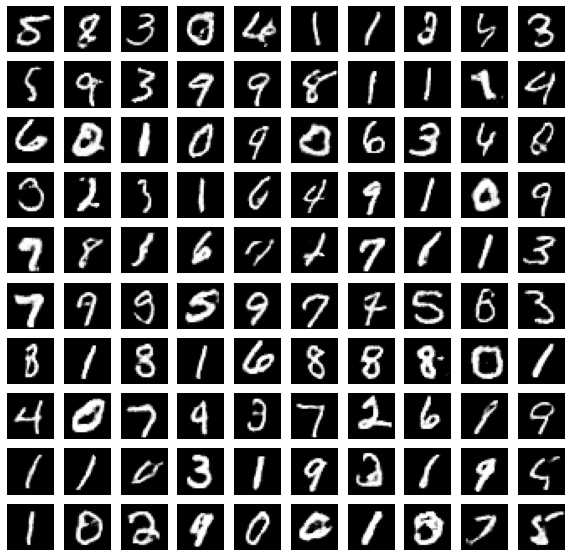

In [21]:
noise = np.random.normal(0, 1, size=(100, 80))
generatorOutput = new_generator(noise, training=False)

fig = plt.figure(figsize=(10,10))

for i in range(100):
    ax = fig.add_subplot(10,10,i+1)
    im = np.clip(generatorOutput[i], 0.0, 1.0).squeeze() * 255
#         ax.set_title(f"({i})")
    ax.imshow(im, cmap="gray", vmin=0, vmax=255)
    ax.axis('off')
    
plt.show()
plt.close(fig)

In [22]:
discriminatorOutput = new_discriminator(generatorOutput, training=False)
print(discriminatorOutput)

tf.Tensor(
[[0.77069455]
 [0.24000795]
 [0.614921  ]
 [0.23397483]
 [0.31141758]
 [0.6530473 ]
 [0.60411894]
 [0.6439442 ]
 [0.33389476]
 [0.4176141 ]
 [0.35066035]
 [0.4702107 ]
 [0.5841414 ]
 [0.45661005]
 [0.61416256]
 [0.47307727]
 [0.55973023]
 [0.67077667]
 [0.05505292]
 [0.25132594]
 [0.7236233 ]
 [0.30628252]
 [0.8133647 ]
 [0.42861626]
 [0.48368523]
 [0.43586394]
 [0.43384287]
 [0.78822136]
 [0.787296  ]
 [0.1108792 ]
 [0.16827972]
 [0.07629954]
 [0.36687654]
 [0.47555372]
 [0.30610007]
 [0.37869284]
 [0.4952293 ]
 [0.5829518 ]
 [0.52587587]
 [0.41281   ]
 [0.46214983]
 [0.2942166 ]
 [0.0668007 ]
 [0.60996526]
 [0.03655852]
 [0.03243903]
 [0.5239    ]
 [0.16124769]
 [0.57067996]
 [0.5765855 ]
 [0.7147037 ]
 [0.3588099 ]
 [0.57118297]
 [0.6375688 ]
 [0.60794955]
 [0.417962  ]
 [0.60837185]
 [0.775788  ]
 [0.31045598]
 [0.7560982 ]
 [0.6265112 ]
 [0.64350295]
 [0.42826763]
 [0.6245948 ]
 [0.9642393 ]
 [0.84762526]
 [0.72841465]
 [0.5164182 ]
 [0.24698469]
 [0.6209786 ]
 [0.30409